# Package Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn.functional as F
import os
from PIL import Image
import pandas as pd

In [3]:
import time
from tqdm.auto import tqdm

for i in tqdm(range(1000)):
    time.sleep(0.01)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [207]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataset 준비하기

In [3]:
train_dataframe = pd.read_csv('/kaggle/input/2023-final/data.csv')
test_df = pd.read_csv('/kaggle/input/2023-final/testdata.csv')

In [4]:
train_dataframe

,Image,Label,Age,Gender,Race
0,10_0_0_20170103200329407.jpg,0,10,0,0
1,10_0_0_20170103200522151.jpg,0,10,0,0
2,10_0_0_20170103233459275.jpg,0,10,0,0
3,10_0_0_20170110220251986.jpg,0,10,0,0
4,10_0_0_20170110220255346.jpg,0,10,0,0
...,...,...,...,...,...
7335,50_1_3_20170117143102562.jpg,4,50,1,3
7336,50_1_3_20170117154120315.jpg,4,50,1,3
7337,50_1_3_20170117185207623.jpg,4,50,1,3
7338,50_1_4_20170105173053477.jpg,4,50,1,4


In [5]:
test_df

,Image,Gender,Race
0,0_0_20170110220546177.jpg,0,0
1,0_0_20170110225451638.jpg,0,0
2,0_4_20170103200409638.jpg,0,4
3,0_0_20161219154556757.jpg,0,0
4,0_0_20161219154956869.jpg,0,0
...,...,...,...
817,1_0_20170120222640234.jpg,1,0
818,1_1_20170112215232959.jpg,1,1
819,1_1_20170117001143232.jpg,1,1
820,1_2_20170116173220910.jpg,1,2


In [6]:
# 클래스 세분화 하기 (10세 단위 -> 5세 단위)
train_dataframe['Label'] = train_dataframe['Age'].apply(lambda x: 0 if x <= 5 else  # 나이가 5 이하인 경우 레이블 0
                                          1 if x <= 10 else  # 나이가 6~10 사이인 경우 레이블 1
                                          2 if x <= 15 else  # 나이가 11~15 사이인 경우 레이블 2
                                          3 if x <= 20 else  # 나이가 16~20 사이인 경우 레이블 3
                                          4 if x <= 25 else  # 나이가 21~25 사이인 경우 레이블 4
                                          5 if x <= 30 else  # 나이가 26~30 사이인 경우 레이블 5
                                          6 if x <= 35 else  # 나이가 31~35 사이인 경우 레이블 6
                                          7 if x <= 40 else  # 나이가 36~40 사이인 경우 레이블 7
                                          8 if x <= 45 else  # 나이가 41~45 사이인 경우 레이블 8
                                          9)  # 나이가 46 이상인 경우 레이블 9


In [7]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train_dataframe, shuffle=True, test_size=0.3, stratify=train_dataframe['Label'])

- train_test_split 함수를 사용하여 train_dataframe을 학습 데이터셋(train_df)과 검증 데이터셋(valid_df)으로 분할합니다.
- shuffle=True는 데이터를 섞을지 여부를 설정하는 매개변수로, True로 설정하면 데이터를 무작위로 섞습니다.
- test_size=0.3은 검증 데이터셋의 크기를 전체 데이터의 30%로 설정합니다.
- stratify=train_dataframe['Label']는 데이터 분할 시 레이블(Label)의 분포를 유지하는 옵션입니다.
- 분할된 학습 데이터셋은 train_df에 저장되고, 검증 데이터셋은 valid_df에 저장됩니다.

In [8]:
print(train_df['Label'].value_counts()) #train Label의 클래스별 데이터 개수
print(valid_df['Label'].value_counts()) #valid Label의 클래스별 데이터 개수

0    748
5    683
3    654
6    582
8    536
9    496
7    441
2    385
4    340
1    273
Name: Label, dtype: int64
0    321
5    293
3    281
6    249
8    230
9    212
7    189
2    165
4    145
1    117
Name: Label, dtype: int64


In [9]:
for index, row in train_df.iterrows():
    print('Image : {}'.format(row["Image"]))  # 이미지에 대한 정보를 출력
    print('Label : {}'.format(row["Label"]))  # 레이블에 대한 정보를 출력
    print('Age   : {}'.format(row["Age"]))  # 나이에 대한 정보를 출력
    break

Image : 26_1_2_20170116180422018.jpg
Label : 5
Age   : 26


In [10]:
class CustomDataset(torch.utils.data.Dataset): # PyTorch의 torch.utils.data.Dataset 클래스 상속
    def __init__(self, dataframe, train='train', transform=None): # 객체 초기화
        if train == 'train':
            self.image_list = []  # 이미지 리스트 초기화
            self.label_list = []  # 레이블 리스트 초기화
            self.gender_list = []  # 성별 리스트 초기화
            self.race_list = []  # 인종 리스트 초기화
            path = '/kaggle/input/2023-final/dataset/{}/{}'  # 이미지 경로 포맷 지정
            for index, row in dataframe.iterrows():
                image_path = row['Image']  # 이미지 경로 가져오기
                image_label = row['Label']  # 이미지 레이블 가져오기
                image_gender = row['Gender']  # 이미지 성별 가져오기
                image_race = row['Race']  # 이미지 인종 가져오기
                image = Image.open(path.format(image_label, image_path)).convert('RGB')  # 이미지 열기 및 RGB로 변환
                if transform is not None:
                    image = transform(image)  # 변환이 지정된 경우 이미지에 변환 적용
                self.image_list.append(image)  # 이미지 리스트에 이미지 추가
                self.label_list.append(image_label)  # 레이블 리스트에 레이블 추가
                self.gender_list.append(image_gender)  # 성별 리스트에 성별 추가
                self.race_list.append(image_race)  # 인종 리스트에 인종 추가

        elif train == 'test':
            self.image_list = []  # 이미지 리스트 초기화
            self.label_list = []  # 레이블 리스트 초기화
            self.gender_list = []  # 성별 리스트 초기화
            self.race_list = []  # 인종 리스트 초기화
            path = '/kaggle/input/2023-final/testset/{}'  # 이미지 경로 포맷 지정
            for index, row in dataframe.iterrows():
                image_path = row['Image']  # 이미지 경로 가져오기
                image_gender = row['Gender']  # 이미지 성별 가져오기
                image_race = row['Race']  # 이미지 인종 가져오기
                image = Image.open(path.format(image_path)).convert('RGB')  # 이미지 열기 및 RGB로 변환
                if transform is not None:
                    image = transform(image)  # 변환이 지정된 경우 이미지에 변환 적용
                self.image_list.append(image)  # 이미지 리스트에 이미지 추가
                self.label_list.append(image_path)  # 레이블 리스트에 이미지 경로 추가
                self.gender_list.append(image_gender)  # 성별 리스트에 성별 추가
                self.race_list.append(image_race)  # 인종 리스트에 인종 추가

    def __len__(self):
        return len(self.image_list)  # 데이터셋의 샘플 수 반환

    def __getitem__(self, idx):
        image = self.image_list[idx]  # 주어진 인덱스에 해당하는 이미지 가져오기
        label = self.label_list[idx]  # 주어진 인덱스에 해당하는 레이블 가져오기
        gender = self.gender_list[idx]  # 주어진 인덱스에 해당하는 성별 가져오기
        race = self.race_list[idx]  # 주어진 인덱스에 해당하는 인종 가져오기

        return image, label, gender, race  # 이미지, 레이블, 성별, 인종을 반환


In [11]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),  # 무작위 회전 (최대 30도)
    transforms.RandomHorizontalFlip(0.5),  # 무작위 수평 반전 (50% 확률)
    transforms.RandomVerticalFlip(0.25),  # 무작위 수직 반전 (25% 확률)
    transforms.RandomAdjustSharpness(0.5),  # 무작위 날카로움 조절 (0.5의 확률로)
    transforms.ColorJitter(),  # 무작위 색상 변조
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 이미지 정규화 (평균, 표준편차  0.5로 설정)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 이미지 정규화 (평균, 표준편차  0.5로 설정)
])

train_dataset = CustomDataset(train_df, train='train', transform=train_transform)  # train 데이터셋 생성
valid_dataset = CustomDataset(valid_df, train='train', transform=test_transform)  # validation 데이터셋 생성
test_dataset = CustomDataset(test_df, train='test', transform=test_transform)  # test 데이터셋 생성


# Dataset에 대한 Data Loaders 구성

In [12]:
batch_size = 40  # 배치 크기 설정

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # train 데이터로더 생성
# train 데이터셋을 사용하여 미니배치 단위로 데이터를 로드하는 데이터로더를 생성합니다.
# batch_size만큼의 데이터를 섞어서 가져오며(shuffle=True), 매 에폭마다 데이터를 섞습니다.

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)  # validation 데이터로더 생성
# validation 데이터셋을 사용하여 미니배치 단위로 데이터를 로드하는 데이터로더를 생성합니다.
# batch_size만큼의 데이터를 섞어서 가져오며(shuffle=True), 매 에폭마다 데이터를 섞습니다.

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)  # test 데이터로더 생성
# test 데이터셋을 사용하여 미니배치 단위로 데이터를 로드하는 데이터로더를 생성합니다.
# batch_size만큼의 데이터를 섞어서 가져오며(shuffle=True), 매 에폭마다 데이터를 섞습니다.


In [15]:
for image, label, gender, race in train_loader:
    print(image.shape)  # 현재 미니배치의 이미지 텐서의 크기 출력
    print(label, label.shape)  # 현재 미니배치의 라벨 정보와 크기 출력
    print(gender)  # 현재 미니배치의 성별 정보 출력
    print(race)  # 현재 미니배치의 인종 정보 출력
    break


torch.Size([40, 3, 200, 200])
tensor([2, 1, 2, 3, 0, 2, 3, 0, 0, 4, 0, 3, 2, 1, 1, 1, 4, 1, 4, 1, 2, 2, 4, 1,
        4, 4, 4, 0, 4, 0, 0, 3, 3, 3, 2, 2, 0, 1, 4, 2]) torch.Size([40])
tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0])
tensor([3, 1, 3, 0, 2, 2, 2, 0, 4, 3, 2, 1, 0, 4, 3, 0, 1, 0, 3, 2, 1, 3, 3, 3,
        1, 3, 0, 2, 2, 0, 0, 4, 1, 2, 0, 0, 0, 1, 0, 1])


In [16]:
for image, path, gender, race in test_loader:
    print(image.shape)  # 현재 미니배치의 이미지 텐서의 크기 출력
    print(path, len(path))  # 현재 미니배치의 이미지 경로와 경로의 개수 출력
    print(gender)  # 현재 미니배치의 성별 정보 출력
    print(race)  # 현재 미니배치의 인종 정보 출력
    break

torch.Size([40, 3, 200, 200])
('1_0_20170117013808240.jpg', '1_2_20161219205514837.jpg', '1_3_20161220223052131.jpg', '0_0_20170119202349909.jpg', '0_3_20170119203909752.jpg', '0_0_20170117202657886.jpg', '1_4_20170117185609466.jpg', '1_4_20170103222949566.jpg', '0_3_20170119205600824.jpg', '0_1_20170113183259413.jpg', '0_0_20170110232818695.jpg', '1_0_20170116200842891.jpg', '0_0_20170110224324459.jpg', '1_0_20170109191823943.jpg', '1_0_20170109212959831.jpg', '1_1_20170112213636293.jpg', '1_0_20170105000707730.jpg', '1_2_20170104013444322.jpg', '0_1_20170117190323954.jpg', '1_2_20170116192946857.jpg', '1_2_20170104020739364.jpg', '0_2_20170116161902902.jpg', '0_0_20170117181222276.jpg', '1_0_20170109204325267.jpg', '1_2_20170105183412088.jpg', '0_2_20170116182447321.jpg', '1_0_20170117131121016.jpg', '0_3_20170104230413577.jpg', '1_1_20170113001152068.jpg', '0_0_20170104210147596.jpg', '1_0_20170104170321489.jpg', '1_2_20170116184134921.jpg', '1_0_20170109212530499.jpg', '0_2_2016121

# Image 확인

In [21]:
# train,test 데이터의 클래스 정의
train_classes = ['0 ~ 5', '6 ~ 10', '11 ~ 15', '16 ~ 20', '21 ~ 25', '26 ~ 30', '31 ~ 35', '36 ~ 40', '41 ~ 45', '46 ~ 50']
test_classes = ['1 ~ 10', '11 ~ 20', '21 ~ 30', '31 ~ 40', '41 ~ 50']

def imshow(img):
    img = img / 2 + 0.5  # 이미지의 값 범위를 [0, 1]에서 원래 범위로 변환 (역정규화)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # 이미지의 차원 순서를 변경 (channel, height, width) -> (height, width, channel)


torch.Size([40, 3, 200, 200]) torch.Size([40])


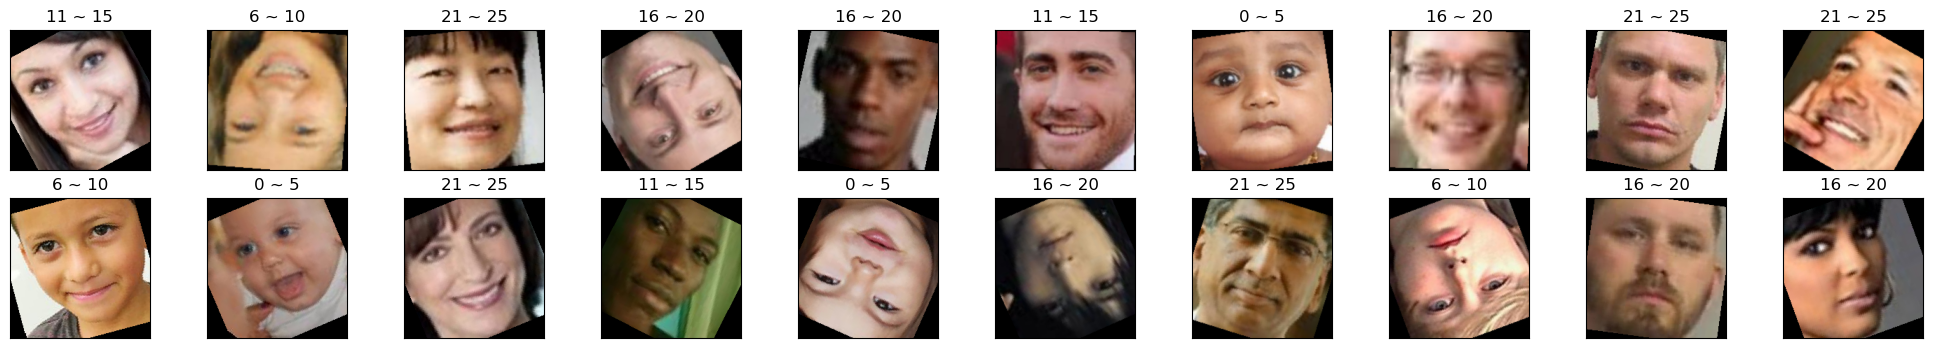

In [22]:
data, label, gender , race =  next(iter(train_loader)) # train_loader에서 다음 배치의 데이터, 레이블, 성별, 인종 정보 가져오기
print(data.shape, label.shape) # 가져온 데이터와 레이블의 shape 출력

fig = plt.figure(figsize=(25, 4)) # 시각화 크기 설정 
data = data.numpy() # Tensor -> Numpy로 변환
for idx in np.arange(20): # 20개 사진 보여주기 
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[]) # 사진 위치 선정
    imshow(data[idx]) # 이미지 보여주기 
    ax.set_title(train_classes[label[idx]]) #제목 설정

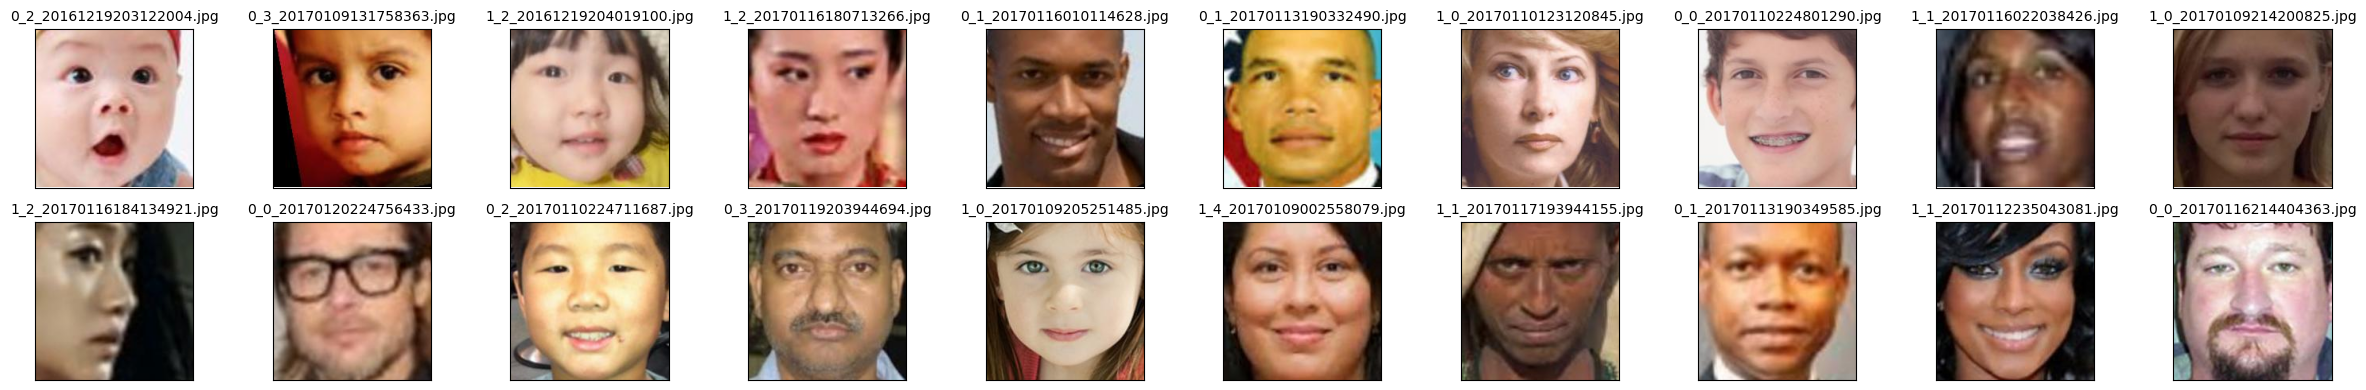

In [23]:
image, file_name, gender, race = next(iter(test_loader)) # test_loader에서 다음 배치의 데이터, 레이블, 성별, 인종 정보 가져오기
image.shape, len(file_name) # 가져온 데이터와 레이블의 shape 출력

fig = plt.figure(figsize=(25, 4)) # 시각화 크기 설정
image = image.numpy() # Tensor -> Numpy로 변환
for idx in np.arange(20): # 20개 사진 보여주기 
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[]) # 사진 위치 선정
    imshow(image[idx]) # 이미지 보여주기 
    ax.set_title(file_name[idx], fontsize = 10) #제목 설정, 폰트크기 설정
    fig.tight_layout() # subplot들 사이의 간격 조정

# Model 설정

In [24]:
import torch.nn as nn
import torch.optim as optim

# CNN 모델구조 정의 
class ConvNet(nn.Module): # nn.Module을 상속받아 모델 구조 정의 
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=1)  # 3채널 입력을 받아 16개의 4x4 커널을 적용하는 합성곱 레이어
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization을 적용하는 2D BatchNorm 레이어
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=1)  # 16채널 입력을 받아 32개의 4x4 커널을 적용하는 합성곱 레이어
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization을 적용하는 2D BatchNorm 레이어
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)  # 32채널 입력을 받아 64개의 4x4 커널을 적용하는 합성곱 레이어
        self.bn3 = nn.BatchNorm2d(64)  # Batch Normalization을 적용하는 2D BatchNorm 레이어
        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=1)  # 64채널 입력을 받아 128개의 4x4 커널을 적용하는 합성곱 레이어
        self.bn4 = nn.BatchNorm2d(128)  # Batch Normalization을 적용하는 2D BatchNorm 레이어

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2)  # 4x4 윈도우 크기를 가지고 2칸씩 이동하는 최대 풀링 레이어

        # Linear layers with BatchNorm1d
        self.fc1 = nn.Linear(10368, 512)  # 10368개의 입력을 받아 512개의 출력을 내보내는 완전 연결 레이어
        self.bn_fc1 = nn.BatchNorm1d(512)  # Batch Normalization을 적용하는 1D BatchNorm 레이어
        self.fc2 = nn.Linear(512, 128)  # 512개의 입력을 받아 128개의 출력을 내보내는 완전 연결 레이어
        self.bn_fc2 = nn.BatchNorm1d(128)  # Batch Normalization을 적용하는 1D BatchNorm 레이어
        self.fc3 = nn.Linear(128, 32)  # 128개의 입력을 받아 32개의 출력을 내보내는 완전 연결 레이어
        self.bn_fc3 = nn.BatchNorm1d(32)  # Batch Normalization을 적용하는 1D BatchNorm 레이어
        self.fc_gender = nn.Linear(1, 2)  # 1개의 입력을 받아 2개의 출력을 내보내는 완전 연결 레이어 ('fc_gender' 레이어 추가)
        self.fc_race = nn.Linear(1, 5)  # 1개의 입력을 받아 5개의 출력을 내보내는 완전 연결 레이어 ('fc_race' 레이어 추가)
        self.fc4 = nn.Linear(39, 10)  # 39개의 입력을 받아 10개의 출력을 내보내는 완전 연결 레이어 ('fc3' 레이어 수정)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)  # 0.5의 확률로 뉴런을 무작위로 꺼주는 드롭아웃 레이어

    def forward(self, x, gender, race):
        x = F.relu(self.bn1(self.conv1(x)))  # 합성곱 -> 배치 정규화 -> ReLU 활성화 함수
        x = self.maxpool(x)  # 최대 풀링
        x = F.relu(self.bn2(self.conv2(x)))  # 합성곱 -> 배치 정규화 -> ReLU 활성화 함수
        x = self.maxpool(x)  # 최대 풀링
        x = F.relu(self.bn3(self.conv3(x)))  # 합성곱 -> 배치 정규화 -> ReLU 활성화 함수
        x = self.maxpool(x)  # 최대 풀링
        x = F.relu(self.bn4(self.conv4(x)))  # 합성곱 -> 배치 정규화 -> ReLU 활성화 함수
        x = self.maxpool(x)  # 최대 풀링
        x = self.dropout(x)  # 드롭아웃
        x = x.view(x.size(0), -1)  # 2차원 텐서를 1차원으로 펼치기
        x = F.relu(self.bn_fc1(self.fc1(x)))  # 완전 연결 -> 배치 정규화 -> ReLU 활성화 함수
        x = self.dropout(x)  # 드롭아웃
        x = F.relu(self.bn_fc2(self.fc2(x)))  # 완전 연결 -> 배치 정규화 -> ReLU 활성화 함수
        x = self.dropout(x)  # 드롭아웃
        x = F.relu(self.bn_fc3(self.fc3(x)))  # 완전 연결 -> 배치 정규화 -> ReLU 활성화 함수
        x = self.dropout(x)  # 드롭아웃
        x_gender = self.fc_gender(gender.float().view(-1, 1))  # 성별 입력에 대해 완전 연결을 수행하고 출력을 내보냄
        x_race = self.fc_race(race.float().view(-1, 1))  # 인종 입력에 대해 완전 연결을 수행하고 출력을 내보냄
        x = torch.cat((x, x_gender, x_race), dim=1)  # 출력에 성별과 인종 정보를 연결
        x = self.fc4(x)  # 완전 연결을 수행하고 최종 출력을 내보냄
        return x


# Create a complete CNN
model = ConvNet()  # ConvNet 클래스의 인스턴스 생성

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # device 정의 (cuda, cpu)
model.to(device)  # 모델을 선택한 장치로 이동시킴


ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AvgPool2d(kernel_size=4, stride=2, padding=0)
  (maxpool): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_fea

# Cost 함수 및 Optimzer 설정

In [25]:
criterion = nn.CrossEntropyLoss()  # 크로스 엔트로피 손실 함수를 사용하여 모델의 출력과 타겟 값 사이의 손실을 계산합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # 학습률 0.001, 가중치 감소(weight decay) 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=35, gamma=0.1)  # step_size(35)마다 학습률 * gamma(0.1)

# Train and Validation

In [ ]:
n_epochs = 40

valid_loss_min = np.Inf  # track change in validation loss

train_loss = torch.zeros(n_epochs, device=device) # train_loss값 0으로 초기화
valid_loss = torch.zeros(n_epochs, device=device) # valid_loss값 0으로 초기화

train_acc = torch.zeros(n_epochs, device=device) # train_accuracy값 0으로 초기화
valid_acc = torch.zeros(n_epochs, device=device) # valid_accuracy값 0으로 초기화

for e in range(n_epochs):
    model.train()  # 모델을 학습 모드로 설정
    for data, labels, gender, race in train_loader:
        data, labels = data.to(device), labels.to(device)
        gender, race = gender.to(device), race.to(device)

        optimizer.zero_grad()  # 그래디언트 초기화
        logits = model(data, gender, race)  # 모델을 통해 예측 logits 계산
        loss = criterion(logits, labels)  # 손실 계산
        loss.backward()  # 역전파 수행
        optimizer.step()  # 가중치 업데이트
        train_loss[e] += loss.item()  # 학습 손실 누적

        ps = F.softmax(logits, dim=1)  # 소프트맥스를 적용하여 클래스별 확률 계산
        top_p, top_class = ps.topk(1, dim=1)  # 가장 높은 확률을 가진 클래스 선택
        equals = top_class == labels.view_as(top_class)  # 예측과 실제 레이블 비교
        train_acc[e] += torch.mean(equals.type(torch.float)).item()  # 정확도 계산

    train_loss[e] /= len(train_loader)  # 평균 학습 손실 계산
    train_acc[e] /= len(train_loader)  # 평균 학습 정확도 계산

    scheduler.step()  # 학습률 스케줄러 업데이트

    with torch.no_grad():
        model.eval()  # 모델을 평가 모드로 설정
        for data, labels, gender, race in valid_loader:
            data, labels = data.to(device), labels.to(device)
            gender = gender.to(device)  # gender 변수를 같은 장치로 이동
            race = race.to(device)  # race 변수를 같은 장치로 이동

            logits = model(data, gender, race)  # 모델을 통해 예측 logits 계산
            loss = criterion(logits, labels)  # 손실 계산
            valid_loss[e] += loss.item()  # 검증 손실 누적

            ps = F.softmax(logits, dim=1)  # 소프트맥스를 적용하여 클래스별 확률 계산
            top_p, top_class = ps.topk(1, dim=1)  # 가장 높은 확률을 가진 클래스 선택
            equals = top_class == labels.view_as(top_class)  # 예측과 실제 레이블 비교
            valid_acc[e] += torch.mean(equals.type(torch.float)).item()  # 정확도 계산

    valid_loss[e] /= len(valid_loader)  # 평균 검증 손실 계산
    valid_acc[e] /= len(valid_loader)  # 평균 검증 정확도 계산

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e + 1, train_loss[e], valid_loss[e]))

    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e + 1, train_acc[e], valid_acc[e]))

    if valid_loss[e] <= valid_loss_min: # e번째 loss값이 기존 최솟값보다 작으면 
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
            valid_loss_min, valid_loss[e]))
        torch.save(model.state_dict(), 'final_model.pt')  # 현재 모델 저장
        valid_loss_min = valid_loss[e]  # 최소 검증 손실 값 갱신


# Accuracy & Loss 분석

In [158]:
model.load_state_dict(torch.load('final_model.pt')) # 모델 불러오기

<All keys matched successfully>

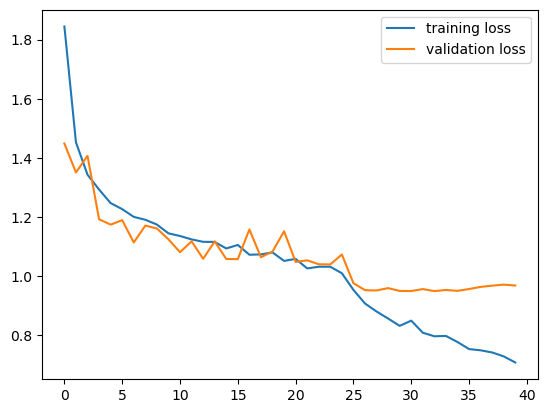

In [159]:
import matplotlib.pyplot as plt

plt.plot(train_loss.cpu(), label='training loss') #train_loss 값을 gpu에서 cpu로 이동, loss 값 시각화
plt.plot(valid_loss.cpu(), label='validation loss') #valid_loss 값을 gpu에서 cpu로 이동, loss 값 시각화
plt.legend() #범례 표시

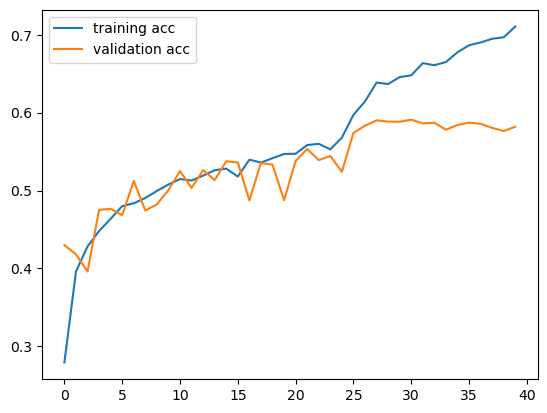

In [160]:
plt.plot(train_acc.cpu(), label='training acc') #train_acc 값을 gpu에서 cpu로 이동, acc 값 시각화
plt.plot(valid_acc.cpu(), label='validation acc') #valid_acc 값을 gpu에서 cpu로 이동, acc 값 시각화
plt.legend() #범례 표시

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

classes = ['1~10', '11~20', '21~30', '31~40', '41~']  # Confusion Matrix에 사용할 Label
classes_cm = [0, 1, 2, 3, 4]  # 클래스 Label
test_loss = 0  # test_loss 초기화
y_pred = []  # 예측값 리스트 생성
y_true = []  # 실제값 리스트 생성
test_acc = 0  # test_acc 초기화

with torch.no_grad():
    model.eval()
    for data, labels, gender, race in valid_loader:
        # CUDA가 사용 가능한 경우 텐서를 GPU로 이동시킴
        data, labels, gender, race = data.to(device), labels.to(device), gender.to(device), race.to(device)
        # 순방향 전파: 입력을 모델에 전달하여 예측 출력 계산
        logits = model(data, gender, race)  
        # 배치 loss 계산
        loss = criterion(logits, labels)
        # 평균 테스트 loss 업데이트
        test_loss += loss.item()

        top_p, top_class = logits.topk(1, dim=1) # 가장 높은 확률과 해당 클래스를 추출
        y_pred.extend(top_class.data.cpu().numpy()) # 예측된 클래스를 리스트에 추가
        y_true.extend(labels.data.cpu().numpy()) # 실제 클래스를 리스트에 추가
        equals = top_class == labels.reshape(top_class.shape) # 예측과 실제 클래스가 일치하는지 확인
        test_acc += torch.sum(equals.type(torch.float)).detach().cpu() # 일치하는 샘플의 개수를 누적하여 정확도 계산
        
    test_loss /= len(valid_loader.dataset) # 평균 테스트 loss 계산
    test_acc /= len(valid_loader.dataset) # 평균 테스트 accuracy 계산
    test_acc *= 100 # 백분율로 변환
    
# confusion matrix 계산
cm = confusion_matrix(y_true, y_pred, labels=classes_cm, normalize='true')

# ConfusionMatrixDisplay 객체 생성
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# confusionmatrix 출력
disp.plot()
plt.show()

# 테스트 정확도 출력
print('테스트 정확도: {}'.format(test_acc))


# 결과 CSV 생성

In [ ]:
id_list = []  # 예측 결과를 저장할 리스트
pred_list = []  # 예측 라벨을 저장할 리스트

with torch.no_grad():
    model.eval()  # 모델을 평가 모드로 설정
    for data, labels, gender, race in test_loader:
        data = data.to(device)  # 데이터를 GPU로 이동 (if available)
        gender = gender.to(device)  # 성별 정보를 GPU로 이동 (if available)
        race = race.to(device)  # 인종 정보를 GPU로 이동 (if available)
        logits = model(data, gender, race)  # 입력과 성별, 인종 정보를 모델에 전달하여 예측 출력 계산

        ps = F.softmax(logits, dim=1)  # 예측 확률을 계산하기 위해 softmax 함수를 적용
        top_p, top_class = ps.topk(1, dim=1)  # 가장 높은 확률을 가진 예측 클래스를 선택
        
        id_list += list(labels)  # 실제 라벨을 id_list에 추가
        pred_list += top_class.view(-1).tolist()  # 예측 라벨을 pred_list에 추가

# 예측 결과를 DataFrame으로 생성
handout_result = pd.DataFrame({'Id': id_list, 'Category': pred_list})

# 결과를 CSV 파일로 저장
handout_result.to_csv('./result.csv', index=False)


In [ ]:
id_list = []  # 예측 결과를 저장할 리스트
pred_list = []  # 예측 라벨을 저장할 리스트

with torch.no_grad():
    model.eval()  # 모델을 평가 모드로 설정
    for data, labels, gender, race in test_loader:
        data = data.to(device)  # 데이터를 GPU로 이동 (if available)
        gender = gender.to(device)  # 성별 정보를 GPU로 이동 (if available)
        race = race.to(device)  # 인종 정보를 GPU로 이동 (if available)
        logits = model(data, gender, race)  # 입력과 성별, 인종 정보를 모델에 전달하여 예측 출력 계산

        ps = F.softmax(logits, dim=1)  # 예측 확률을 계산하기 위해 softmax 함수를 적용
        top_p, top_class = ps.topk(1, dim=1)  # 가장 높은 확률을 가진 예측 클래스를 선택
        
        id_list += list(labels)  # 실제 라벨을 id_list에 추가
        pred_list += top_class.view(-1).tolist()  # 예측 라벨을 pred_list에 추가

# 예측 결과를 DataFrame으로 생성
handout_result = pd.DataFrame({'Id': id_list, 'Category': pred_list})

# 결과를 CSV 파일로 저장
handout_result.to_csv('./result.csv', index=False)


In [ ]:
handout_result